In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

2023-09-06 13:33:36.337895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 13:33:36.421903: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 13:33:36.443284: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-06 13:33:36.868247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
IMG_SHAPE = (256, 256)
N_CHANNELS = 1
INPUT_SHAPE = IMG_SHAPE + (N_CHANNELS,)
N_CLASSES = 1
OUTPUT_SHAPE = IMG_SHAPE + (N_CLASSES,)
BATCH_SIZE = 20
DATASET_PATH = f"{os.path.expanduser('~')}/Datasets/segthor_extracted"

In [5]:
import segmentation_models as sm
dice_score = sm.metrics.FScore(threshold=0.5)
precision_score = tf.keras.metrics.Precision(thresholds=0.5)
recall_score = tf.keras.metrics.Recall(thresholds=0.5)
iou_score = sm.metrics.IOUScore(threshold=0.5)

Segmentation Models: using `keras` framework.


2023-09-05 09:00:44.145329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 09:00:44.145781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-05 09:00:44.146336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-05 09:00:44.146799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [6]:
from model import EfficientUnet
model = EfficientUnet(input_shape = INPUT_SHAPE)
model.load_weights(f"records/{model.name}/checkpoint/{model.name}")

# Get Training History

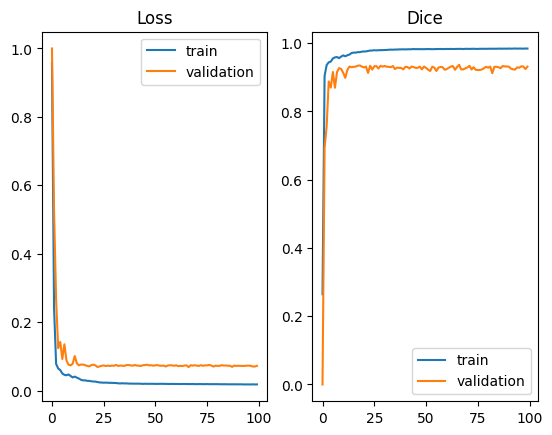

In [7]:
import pickle
import matplotlib.pyplot as plt

with open(f"records/{model.name}/history", "rb") as f:
    history = pickle.load(f)

train_loss = history["loss"]
val_loss = history["val_loss"]

train_f1 = history["f1-score"]
val_f1 = history["val_f1-score"]

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train", "validation"])

plt.subplot(1, 2, 2)
plt.title("Dice")
plt.plot(train_f1)
plt.plot(val_f1)
plt.legend(["train", "validation"])

# Metrics Without Post Processing

In [13]:
import numpy as np
import preprocessing
from glob import glob
from generators import PerPatientSliceGenerator

preprocessing_pipeline = preprocessing.Pipeline([
    preprocessing.windowing(-500, 60),
    preprocessing.norm, 
    preprocessing.resize(IMG_SHAPE),
    preprocessing.expand_dims
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/test/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PerPatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=OUTPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))
    
for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

dice : 0.6682019233703613
precision : 0.5223750472068787
recall : 0.9388577938079834
iou_score : 0.5082618594169617


# Metrics With Post Processing

In [15]:
import numpy as np
import preprocessing
import postprocessing
from glob import glob
from generators import PerPatientSliceGenerator

preprocessing_pipeline = preprocessing.Pipeline([
    preprocessing.windowing(-500, 60),
    preprocessing.norm, 
    preprocessing.resize(IMG_SHAPE),
    preprocessing.expand_dims
])

metrics = {
    "dice":[],
    "precision":[],
    "recall":[],
    "iou_score":[],
}

patients_test = glob(DATASET_PATH + '/test/*')

for patient in patients_test:
    patient_dataset = tf.data.Dataset.from_generator(
        PerPatientSliceGenerator(patient, preprocessing_pipeline),
        output_signature=
        (
            tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
            tf.TensorSpec(shape=OUTPUT_SHAPE, dtype=tf.float32)
        )
    )

    volume_true = []
    for (x, y) in patient_dataset:
        volume_true.append(y)
    volume_true = np.squeeze(np.array(volume_true))
    volume_pred = model.predict(patient_dataset.batch(20), verbose=0)
    volume_pred = np.round(volume_pred)
    volume_pred = np.squeeze(volume_pred)
    volume_pred = postprocessing.biggest_3D_object(volume_pred)

    metrics["dice"].append(dice_score(volume_true, volume_pred))
    metrics["precision"].append(precision_score(volume_true, volume_pred))
    metrics["recall"].append(recall_score(volume_true, volume_pred))
    metrics["iou_score"].append(iou_score(volume_true, volume_pred))

for k in metrics.keys():
    print(f"{k} : {np.mean(metrics[k])}")

dice : 0.7938454747200012
precision : 0.6085526943206787
recall : 0.9262600541114807
iou_score : 0.6638147234916687


# Sample Images

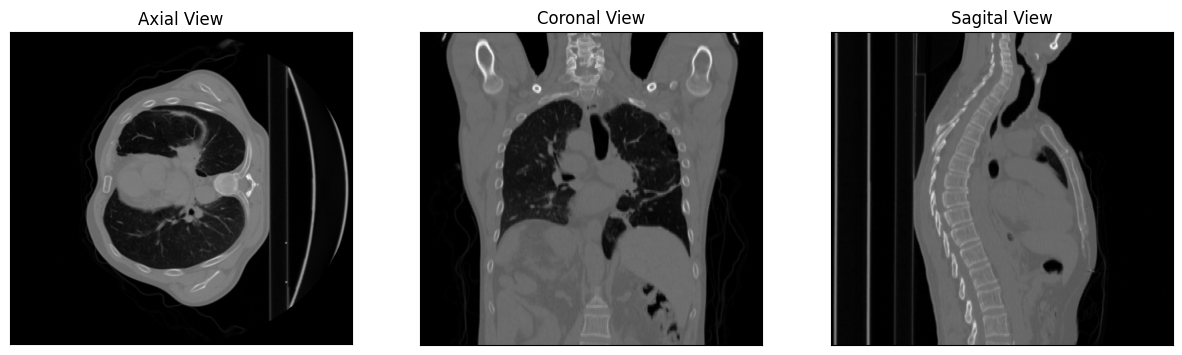

In [87]:
import numpy as np
import preprocessing
from scipy import ndimage
import matplotlib.pyplot as plt
from generators import PerPatientSliceGenerator

patient_01 = DATASET_PATH + '/test/Patient_01'

preprocessing_pipeline = preprocessing.Pipeline([
    preprocessing.expand_dims
])

patient_dataset = tf.data.Dataset.from_generator(
    PerPatientSliceGenerator(patient_01, preprocessing_pipeline),
    output_signature=
    (
        tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(512, 512, 1), dtype=tf.float32)
    )
)

import nibabel as nib

nib_file = nib.load('/home/arthur_guilherme/Datasets/segthor/train/Patient_01/Patient_01.nii.gz')
thickness = nib_file.header.get_zooms()
thickness = list(thickness)
thickness.reverse()
axial_aspect_ratio = thickness[2]/thickness[1]
coronal_aspect_ratio = thickness[0]/thickness[1]
sagital_aspect_ratio = thickness[0]/thickness[2]

volume_ct = []
volume_label = []
for (x, y) in patient_dataset:
    volume_ct.append(x)
    volume_label.append(y)
volume_ct = np.squeeze(np.array(volume_ct))
volume_label = np.squeeze(np.array(volume_label))

axial = volume_ct[volume_ct.shape[0]//2, :, :]
coronal = ndimage.rotate(volume_ct[:, :, volume_ct.shape[2]//2], 180)
sagital = ndimage.rotate(volume_ct[:, volume_ct.shape[1]//2, :], 180)

# plt.figure(figsize=(12, 12))

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols=3)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.set_title("Axial View")
ax1.imshow(axial, cmap="gray", aspect=0.912)
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax2.set_title("Coronal View")
ax2.imshow(coronal, cmap="gray", aspect=coronal_aspect_ratio)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

ax3.set_title("Sagital View")
ax3.imshow(sagital, cmap="gray", aspect=sagital_aspect_ratio)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.savefig("slices.png", transparent=True, bbox_inches='tight')